## _*3SAT  is an NP complete problem*_


We report the classification of the problems P vs NP
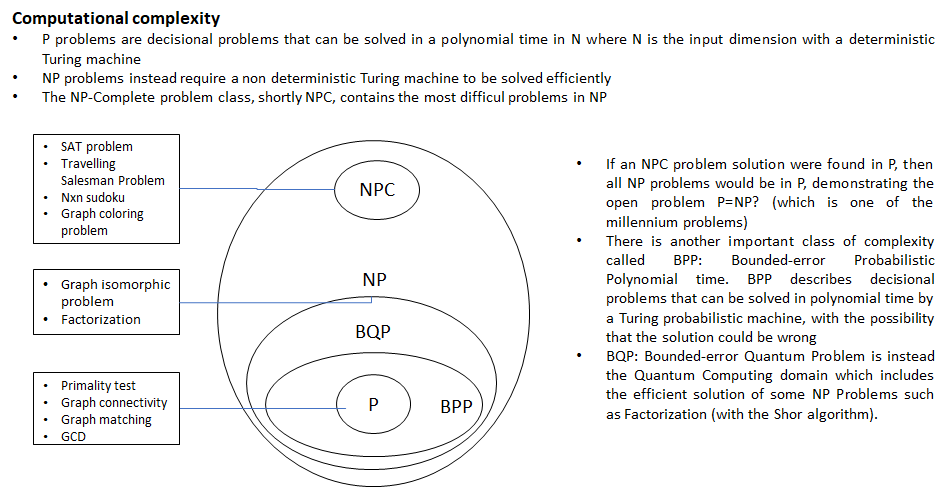

## _*Utilizziamo la ricerca di Grover per un problema di 3SAT*_

In informatica il problema della soddisfazione booleana (talvolta chiamato problema della soddisfazione proposizionale e abbreviato in SATISFABILITY o SAT) è il problema di determinare se esiste un'interpretazione che soddisfi una data formula booleana. In altre parole, si chiede se le variabili di una data formula booleana possono essere coerentemente sostituite da valori VERO o FALSO in modo che la formula sia globalmente VERA. Se questo è il caso, la formula viene definita soddisfacente. Se invece non esiste tale assegnazione, la funzione espressa dalla formula è FALSA per tutte le possibili assegnazioni delle variabili e la formula è insoddisfacente. Ad esempio, la formula "a AND NOT b" è soddisfacente perché è possibile trovare i valori a = VERO e b = FALSO, che determinano (a E NON b) = VERO. Al contrario, "a AND NOT a" è insoddisfacente. 

In [2]:
import math
import warnings
import pylab
import numpy as np
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.circuit.library.phase_oracle import PhaseOracle

In [3]:
!pip install tweedledum

  Using cached tweedledum-1.1.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (10.0 kB)
Using cached tweedledum-1.1.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (929 kB)


In [4]:
import tweedledum

Supponiamo di avere un problema SAT per il quale vogliamo trovare soluzioni utilizzando la combinazione di Grover e SAT oracle. Il problema SAT è specificato nel formato DIMACS CNF. 
Se guardiamo al sito https://people.sc.fsu.edu/~jburkardt/data/cnf/cnf.html troviamo questo semplice 
esempio di espressione booleana in 3 variabili e 5 clausole (in cui le variabili sono le x()e le clausole sono OR e AND): 

Il CNF di questa istanza 3-SAT contiene 3 variabili e 5 clausole:

$(\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$

equivalente a 

    (NOT v_1 OR (NOT v_2) OR (NOT v_3)) 
    AND
    (v_1 OR (NOT v_2) OR v_3) 
    AND
    (v_1 OR v_2 OR (NOT v_3)) 
    AND
    (v_1 OR (NOT v_2) OR (NOT v_3)) 
    AND
    (NOT v_1 OR v_2 OR v_3)
 
può essere espresso nella forma:

      c simple_v3_c3.cnf
      c
      p cnf 3 5
      -1 -2 -3 0
       1 -2  3 0
       1  2 -3 0
       1 -2 -3 0
      -1  2  3 0
dove:
- "c" sta per commento,
- "p" è utilizzato per descrivere il formato, il numero di variabili (3) e il numero di clausole (2),
- "-" rappresenta la negazione della variabile NOT x(3),
- "0" è un terminatore di stringa.

Assegnamo il contenuto del file alla variabile input_3sat_instance avendo cura di terminare ogni linea con \n



In [5]:
input_3sat_instance = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

In [6]:
print(input_3sat_instance)


c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0



Si può verificare che questa istanza di problema 3-SAT ha tre soluzioni soddisfacenti:

$(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$

Oppure, espresso con la notazione DIMACS:

`1 -2 3`, or `-1 -2 -3`, or `1 2 -3`.

Infatti:

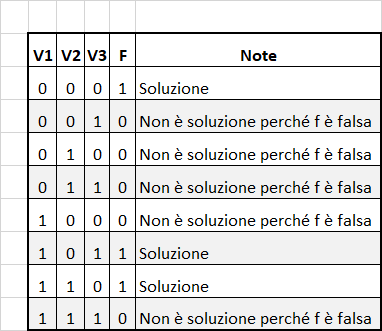

Con l'input di questo problema di esempio, creiamo il corrispondente `oracolo` per la nostra ricerca `Grover`. In particolare, utilizziamo il componente `PhaseOracle`, che supporta il parsing di stringhe in formato DIMACS-CNF e la costruzione del circuito oracolo corrispondente.

In [7]:
import os
import tempfile
from qiskit.exceptions import MissingOptionalLibraryError

fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = None
try:
    oracle = PhaseOracle.from_dimacs_file(file_name)
except MissingOptionalLibraryError as ex:
    print(ex)
finally:
    os.remove(file_name)

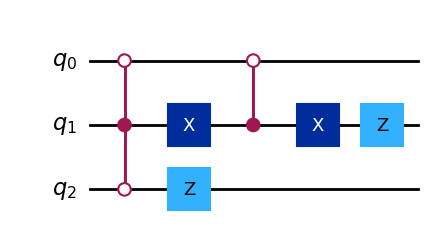

In [8]:
fp = tempfile.NamedTemporaryFile(mode='w+t', delete=False)
fp.write(input_3sat_instance)
file_name = fp.name
fp.close()
oracle = PhaseOracle.from_dimacs_file(file_name)
oracle.draw()

L' 'oracolo' può ora essere usato per creare un'istanza di Grover:

### Il GroverOperator

Il GroverOperator prende il circuito oracolo e restituisce un circuito composto dal circuito oracolo stesso e da un circuito che amplifica gli stati segnati dall'oracolo (diffusore). Qui scomponiamo il circuito per vedere le porte all'interno dell'operatore:

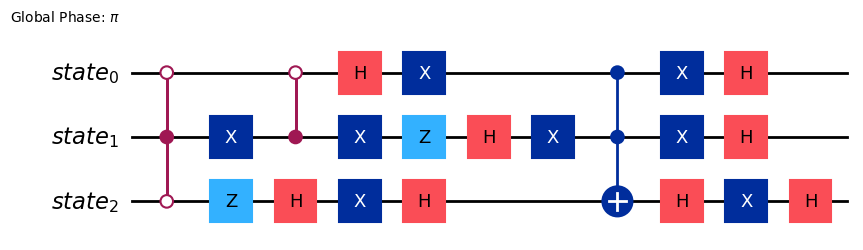

In [9]:
#
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [10]:
#calcoliamo il numero ottimale di ripetizioni del blocco oracolo+diffusore
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(oracle) / 2**grover_op.num_qubits)))
)
if optimal_num_iterations == 0 :
    optimal_num_iterations = 1

### Circuito di Grover completo

Un esperimento di Grover completo inizia con un gate di Hadamard su ogni qubit, creando una sovrapposizione uniforme di tutti gli stati della base computazionale, seguita dall'operatore di Grover (`grover_op`) ripetuto il numero ottimale di volte.  Qui utilizziamo il metodo `QuantumCircuit.power(INT)` per applicare ripetutamente l'operatore Grover.

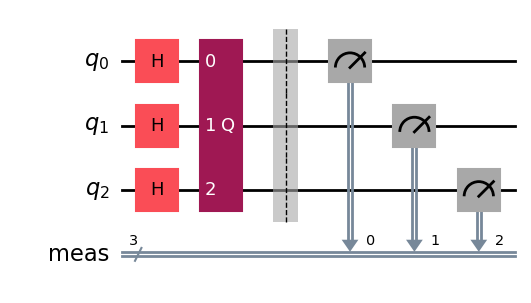

In [11]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [13]:
# Per eseguire sul quantum computer scegliamo il backend più conveniente se vogliamo il QC reale mettiamo in False l'assegnazione simulator=True
#attenzione perché l'esecuzione può prendere molto tempo perché restate in coda a tutte le richieste
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=True)
backend.name

qiskit_runtime_service.__init__:INFO:2024-03-23 06:01:19,733: Default instance: ibm-q/open/main


'ibmq_qasm_simulator'

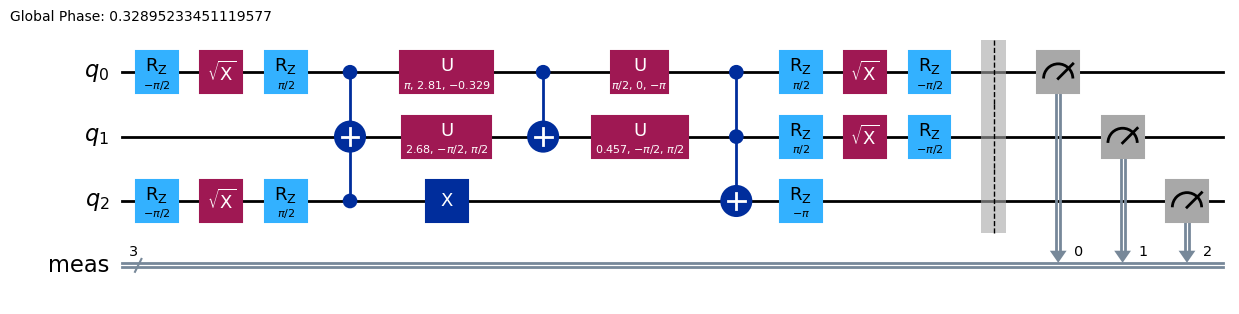

In [14]:
#utilizziamo il transpiler per ottimizzare il circuito
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_ibm = pm.run(qc)
circuit_ibm.draw(output="mpl", idle_wires=False, style="iqp")

Possiamo quindi configurare il backend ed eseguire l'istanza di Grover per ottenere il risultato:

In [15]:
def inverti_chiavi(dizionario):
    nuovo_dizionario = {}
    for chiave in dizionario:
        chiave_invertita = chiave[::-1]  # Inverte la stringa della chiave
        nuovo_dizionario[chiave_invertita] = dizionario[chiave]
    return nuovo_dizionario

In [18]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
 
#circuit = QuantumCircuit(2)
#circuit.x(0)
#circuit.x(1)
#circuit.measure_all()
 
#sampler = Sampler()
#result = sampler.run(circuit, shots=200).result()
#quasi_dists = result.quasi_dists
 
#print("Quasi-dists: ", quasi_dists)
#print("Result: ", result)

#backend = AerSimulator()
sampler = Sampler()
quantum_instance = sampler.run(circuit_ibm, shots=1024).result()
#grover = Grover(quantum_instance=quantum_instance)
#result = None
#if problem is not None:
#    result = grover.amplify(problem)
#    print(result.assignment)
dist = sampler.run(circuit_ibm, skip_transpilation=True, shots=10000).result().quasi_dists[0]
new_dist = inverti_chiavi(dist.binary_probabilities())
#print (new_dist)
#print (max(dist.binary_probabilities(), key=lambda k: dist.binary_probabilities()[k]))
print (max(new_dist, key=lambda k: new_dist[k]))

101


Come si è visto, si ottiene una soluzione soddisfacente al problema 3-SAT specificato. Ed è effettivamente una delle tre soluzioni soddisfacenti.

Poiché abbiamo utilizzato l'aer-simulator, viene restituito anche il risultato completo della misurazione, come mostrato nel grafico sottostante, dove si può notare che le stringhe binarie '000', '110' e '101', corrispondenti alle tre soluzioni soddisfacenti, hanno tutte alte probabilità associate.

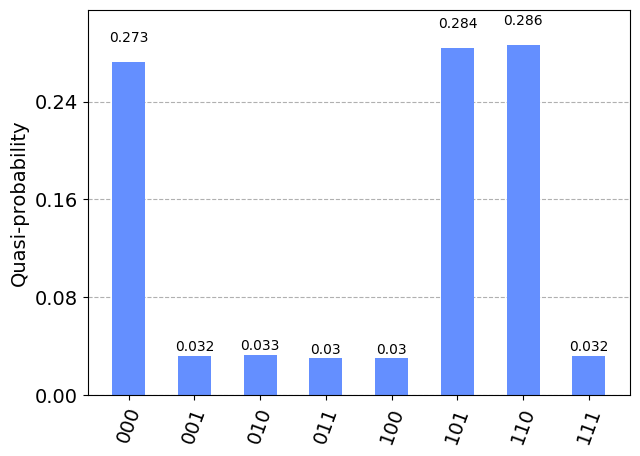

In [17]:
from qiskit.visualization import plot_distribution
#plot_distribution(dist.binary_probabilities())
plot_distribution(new_dist)

Ora provate a eseguire un piccolo problema SAT.
Per esempio, scoprite che cosa succede se provate a eseguire

(v_1 or v_2 or (not v_3)) and ((not v_1) or (not v_2) or (not v_3)) and ((not v_1) or v_2 or v_3)